In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

### Join train features with labels

In [3]:
train = train.join(labels, on='series_id', rsuffix='_')
train.drop('series_id_', axis=1, inplace=True)
print(train.shape)
display(train.head())

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


### Feature engineering

In [4]:
def agg_features(df):
    df['orientation'] = df['orientation_X'] + df['orientation_Y'] + df['orientation_Z'] + df['orientation_W']
    df['angular_velocity'] = df['angular_velocity_X'] + df['angular_velocity_Y'] + df['angular_velocity_Z']
    df['linear_acceleration'] = df['linear_acceleration_X'] + df['linear_acceleration_Y'] + df['linear_acceleration_Z']
    
agg_features(train)
agg_features(test)

### Pre process the labels

In [5]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [6]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id', 'measurement_number', 
            'orientation', 'angular_velocity', 'linear_acceleration']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0, stratify=train['series_id'])
X_train.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
X_val.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
features = X_train.columns
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe())

Train shape (390144, 13)
Validation shape (97536, 13)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,orientation,angular_velocity,linear_acceleration
count,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000
mean,-0.018011,0.074961,0.012443,-0.003798,0.000311,0.008419,-0.019182,0.130067,2.888780,-9.362221,0.065594,-0.010452,-6.343373
std,0.685686,0.708248,0.105976,0.104298,0.117848,0.088657,0.229066,1.872103,2.144853,2.840186,1.024324,0.201622,4.631869
min,-0.989100,-0.989650,-0.162770,-0.156620,-2.014300,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000,-1.646160,-2.505400,-183.983100
25%,-0.704950,-0.689013,-0.089480,-0.106020,-0.040592,-0.033149,-0.090782,-0.530183,1.958300,-10.189000,-0.787026,-0.100322,-8.003705
50%,-0.105735,0.237710,0.031939,-0.018676,0.000107,0.005434,-0.005435,0.125880,2.881400,-9.364500,0.015002,-0.003815,-6.358480
75%,0.651810,0.809560,0.122870,0.097250,0.040571,0.048052,0.064631,0.791440,3.801600,-8.521300,0.898518,0.083212,-4.673255
max,0.989100,0.988980,0.155710,0.154770,2.282200,0.936190,1.272500,36.797000,55.948000,65.839000,1.618510,2.674690,115.418700


### Scale the data

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test[features])

### Model

In [8]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [9]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 153       
Total params: 3,657
Trainable params: 3,657
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, verbose=2)

Train on 390144 samples, validate on 97536 samples
Epoch 1/100
 - 39s - loss: 1.4058 - val_loss: 1.2330
Epoch 2/100
 - 35s - loss: 1.1889 - val_loss: 1.1420
Epoch 3/100
 - 37s - loss: 1.1277 - val_loss: 1.1150
Epoch 4/100
 - 36s - loss: 1.0742 - val_loss: 1.0392
Epoch 5/100
 - 36s - loss: 1.0287 - val_loss: 1.0034
Epoch 6/100
 - 35s - loss: 0.9920 - val_loss: 0.9741
Epoch 7/100
 - 35s - loss: 0.9633 - val_loss: 0.9516
Epoch 8/100
 - 36s - loss: 0.9403 - val_loss: 0.9169
Epoch 9/100
 - 37s - loss: 0.9171 - val_loss: 0.8984
Epoch 10/100
 - 36s - loss: 0.8937 - val_loss: 0.8883
Epoch 11/100
 - 35s - loss: 0.8709 - val_loss: 0.8848
Epoch 12/100
 - 37s - loss: 0.8527 - val_loss: 0.8772
Epoch 13/100
 - 36s - loss: 0.8341 - val_loss: 0.8005
Epoch 14/100
 - 36s - loss: 0.8170 - val_loss: 0.8015
Epoch 15/100
 - 35s - loss: 0.8040 - val_loss: 0.7919
Epoch 16/100
 - 36s - loss: 0.7896 - val_loss: 0.8336
Epoch 17/100
 - 36s - loss: 0.7774 - val_loss: 0.7917
Epoch 18/100
 - 37s - loss: 0.7658 - val

#### Model loss plot

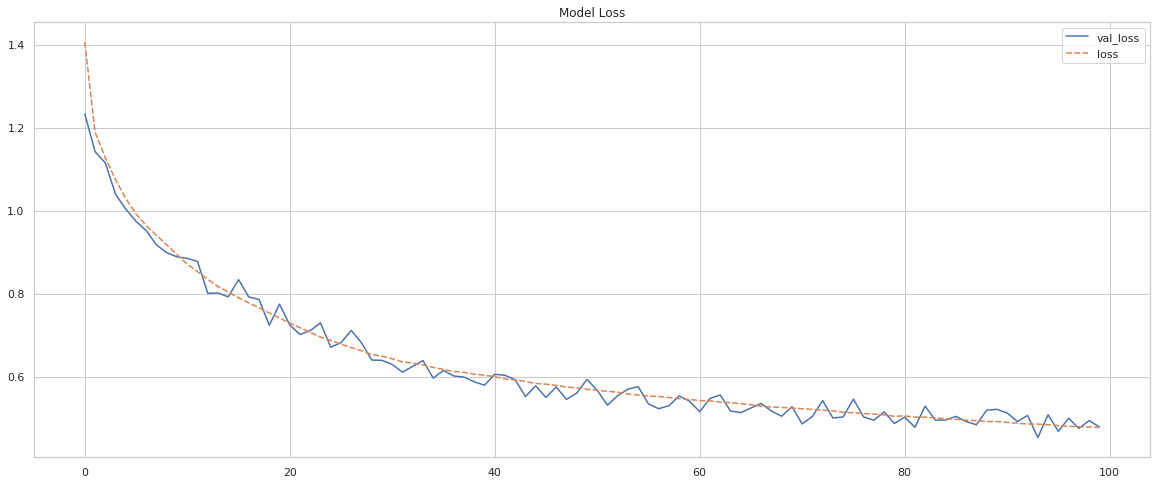

In [11]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [12]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.8229141035104987
Validation accuracy 0.8222297408136483


#### Model confusion matrix

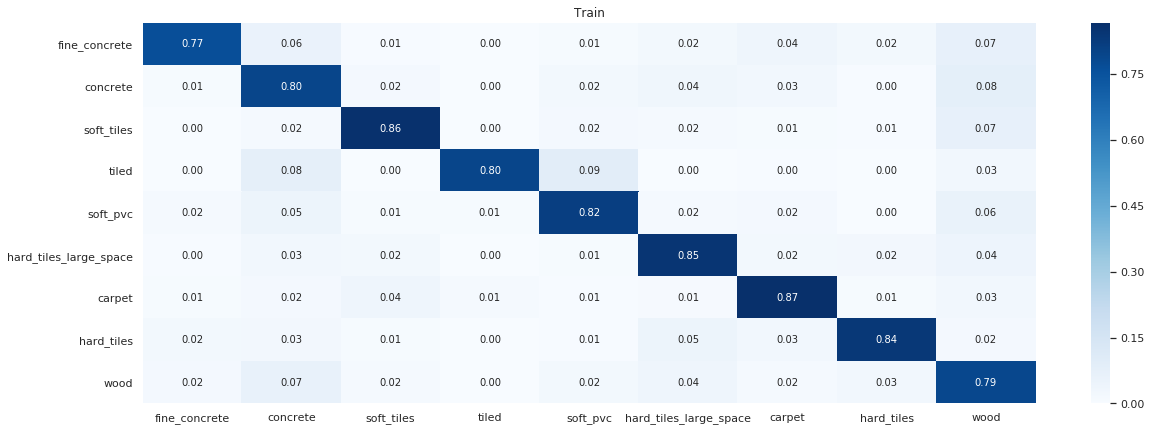

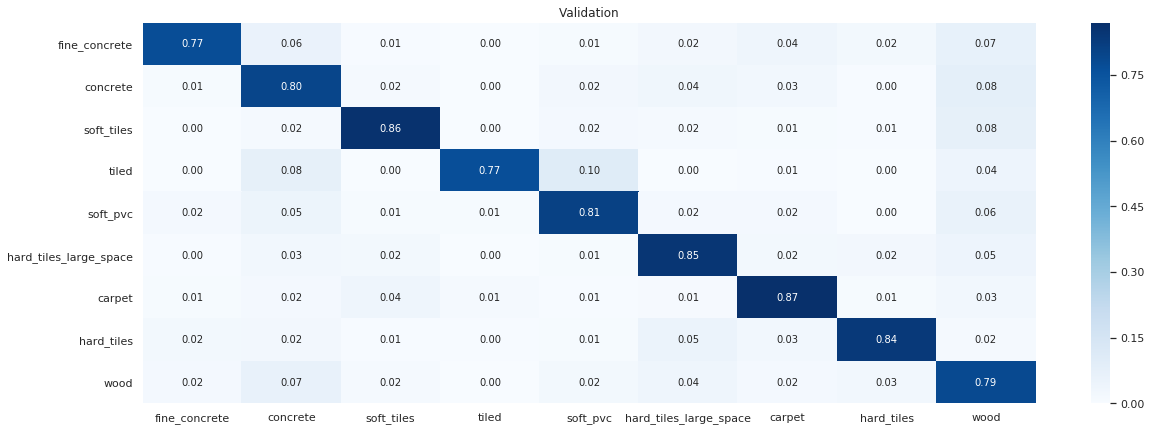

In [13]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(X_test)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)